# GPU Kernel Performance 

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

df = pd.read_csv('sgemm_product.csv')

sns.set()
df = df.astype(float)

plt.figure(figsize=(10, 10))
sns.heatmap(df.corr(), square=True, cmap='RdYlGn')
plt.show()

<Figure size 1000x1000 with 2 Axes>

## Tratamento inicial dos dados

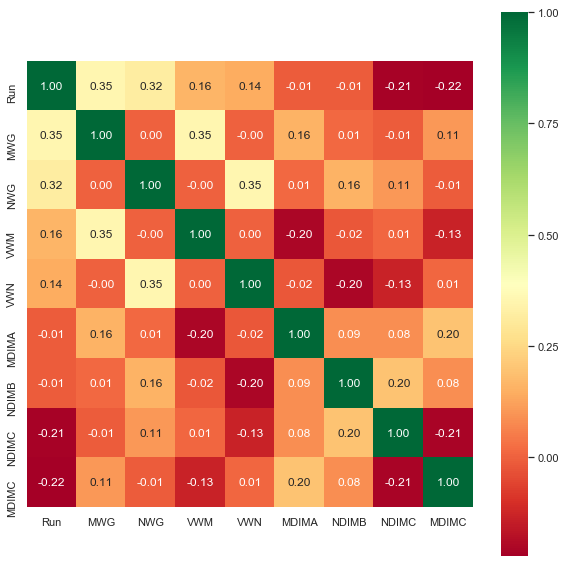

,MWG,NWG,MDIMC,NDIMC,MDIMA,NDIMB,VWM,VWN,Run
count,241600.000000,241600.000000,241600.000000,241600.000000,241600.000000,241600.000000,241600.000000,241600.000000,241600.000000
mean,80.415364,80.415364,13.935894,13.935894,17.371126,17.371126,2.448609,2.448609,217.571953
std,42.469220,42.469220,7.873662,7.873662,9.389418,9.389418,1.953759,1.953759,368.750161
min,16.000000,16.000000,8.000000,8.000000,8.000000,8.000000,1.000000,1.000000,13.317500
25%,32.000000,32.000000,8.000000,8.000000,8.000000,8.000000,1.000000,1.000000,40.667500
50%,64.000000,64.000000,8.000000,8.000000,16.000000,16.000000,2.000000,2.000000,69.790000
75%,128.000000,128.000000,16.000000,16.000000,32.000000,32.000000,4.000000,4.000000,228.387500
max,128.000000,128.000000,32.000000,32.000000,32.000000,32.000000,8.000000,8.000000,3341.507500


In [2]:
from sklearn import preprocessing

df['Run'] = df[['Run1 (ms)', 'Run2 (ms)','Run3 (ms)','Run4 (ms)']].mean(axis=1)
df.drop(df.columns[list(range(10, 18))], axis=1, inplace=True)
df.drop(df.columns[[2, 7]], axis=1, inplace=True)
df.head()

correlation = df.corr(method='pearson')
columns = correlation.nlargest(10, 'Run').index
correlation_map = np.corrcoef(df[columns].values.T)
plt.figure(figsize=(10, 10))
sns.set(font_scale=1.0)
heatmap = sns.heatmap(correlation_map, cbar=True, annot=True, square=True, fmt='.2f', yticklabels=columns.values, xticklabels=columns.values,cmap='RdYlGn')

plt.show()

df.describe()

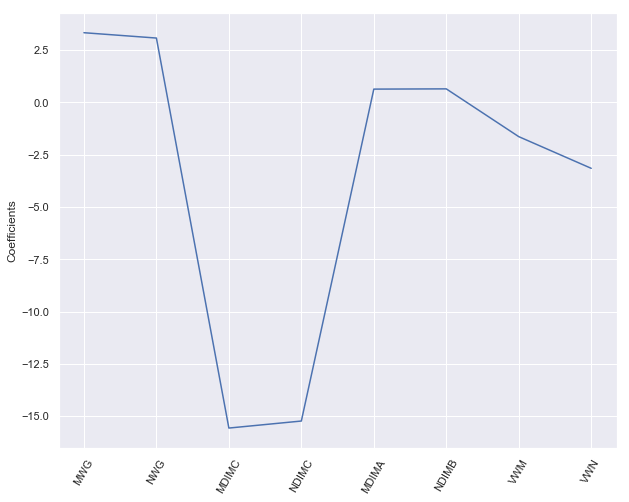

In [3]:
from sklearn.linear_model import Lasso
from sklearn.model_selection import train_test_split

X = df.drop('Run',axis=1).values
y = df['Run'].values
X_train, X_test, y_train, y_test =  train_test_split(X,y, test_size=0.3)

names = df.drop('Run',axis=1).columns

lasso = Lasso(alpha=0.1)
lasso_coef = lasso.fit(X,y).coef_
plt.figure(figsize=(10, 8))
plt.plot(range(len(names)),lasso_coef)
plt.xticks(range(len(names)),names,rotation=60)
plt.ylabel('Coefficients')
plt.show()

In [4]:
from sklearn.metrics import mean_absolute_error, r2_score

y_pred = lasso.predict(X_test)

print('MAE: {}'.format(mean_absolute_error(y_test, y_pred)))
print('R2: {}'.format(r2_score(y_test, y_pred)))

MAE: 175.32465313336766
R2: 0.38893935196068197


## Ridge Regression

### Resíduos

![Linear Regression](https://raw.githubusercontent.com/icaropires/gpu-kernel-performance/master/images/linear_regression.png)

### Loss Function

![Loss Function](https://raw.githubusercontent.com/icaropires/gpu-kernel-performance/master/images/loss_function.png)

### Ridge Loss Function

![Ridge Loss Function](https://raw.githubusercontent.com/icaropires/gpu-kernel-performance/master/images/ridge_loss_function.png)

### Experimento variando o alpha

In [5]:
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_absolute_error, r2_score

maes, r2s = [], []

for n in range(0,10):
    ridge = Ridge(alpha = n/10, normalize=True, solver='lsqr')
    ridge.fit(X_train,y_train)

    y_pred = ridge.predict(X_test)
    maes += [mean_absolute_error(y_test, y_pred)]
    r2s += [r2_score(y_test, y_pred)]

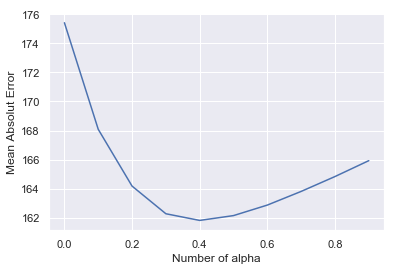

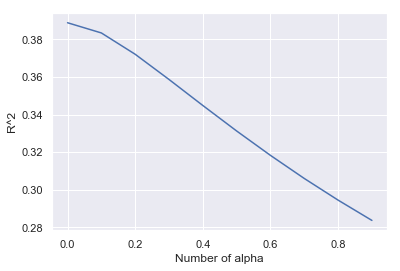

In [6]:
plt.plot([x/10 for x in range(0,10)], maes)
plt.xlabel('Number of alpha')
plt.ylabel('Mean Absolut Error')
plt.show()

plt.figure()
plt.plot([x/10 for x in range(0,10)], r2s)
plt.xlabel('Number of alpha')
plt.ylabel('R^2')
plt.show()

### Melhores resultados

In [7]:
ridge = Ridge(alpha = 0.4, normalize=True, solver='lsqr')
ridge.fit(X_train,y_train)

y_pred = ridge.predict(X_test)
print('MAE:', mean_absolute_error(y_test, y_pred))
print('R2:', r2_score(y_test, y_pred))

MAE: 161.81551157005228
R2: 0.3448158070598226


## Relatório


|   Métrica/Modelo    |  SGDRegressor |  Ridge  | CrossValidations | DecisionTree |  Baseline: Lasso |
|:-------------------:|:-------------:|:-------:|:----------------:|:------------:|:----------------:|
| Mean Absolute Error |   146.4761    |   161   |      175.34      |    74.08     |   176.2592       |
|          R2         |     0.2609    |   0.34  |       0.40       |     0.73     |    0.38805       |